# Training an Attention Model on Tensorflow Datasets
## Prerequisites

In [82]:
import json
import math
import os
from typing import Any, Callable, Tuple

import numpy as np
import pandas as pd
import tensorflow as tf
import official.nlp.modeling as tfnlp
from mmproteo.utils import log, paths, utils, visualization
from mmproteo.utils.formats.tf_dataset import DatasetLoader
from mmproteo.utils.ml import callbacks, evaluation, layers, losses

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)

In [3]:
logger = log.DummyLogger(verbose=False)

INFO: Printing to Stdout


## Configuration

In [4]:
%pwd

'/tf/workspace/notebooks'

In [5]:
PROJECT = "PXD010000"
DUMP_PATH = os.path.join("..", "dumps", PROJECT)
TRAINING_COLUMNS_DUMP_PATH = os.path.join(DUMP_PATH, "training_columns")
FILES_PATH = os.path.join(TRAINING_COLUMNS_DUMP_PATH, "*_mzmlid.parquet")
STATISTICS_FILE_PATH = os.path.join(TRAINING_COLUMNS_DUMP_PATH, "statistics.parquet")
DATASET_DUMP_PATH = os.path.join(TRAINING_COLUMNS_DUMP_PATH, "tf_datasets")
PROCESSING_FILE_PATH = os.path.join(DATASET_DUMP_PATH, "processing_info.json")

In [6]:
SEQ = 'peptide_sequence'

In [7]:
with open(PROCESSING_FILE_PATH, 'r') as file:
    PROCESSING_INFO = json.loads(file.read())
PROCESSING_INFO

{'padding_characters': {'peptide_sequence': '_',
  'mz_array': 0.0,
  'intensity_array': 0.0},
 'padding_lengths': {'mz_array': 2354,
  'intensity_array': 2354,
  'peptide_sequence': 50},
 'idx_to_char': {'0': 'A',
  '1': 'C',
  '2': 'D',
  '3': 'E',
  '4': 'F',
  '5': 'G',
  '6': 'H',
  '7': 'I',
  '8': 'K',
  '9': 'L',
  '10': 'M',
  '11': 'M(Oxidation)',
  '12': 'N',
  '13': 'P',
  '14': 'Q',
  '15': 'R',
  '16': 'S',
  '17': 'T',
  '18': 'V',
  '19': 'W',
  '20': 'Y',
  '21': '_'},
 'normalization': {'intensity_array': '<function base_peak_normalize at 0x7fa6046d5158>'},
 'split_value_columns': ['species', 'istrain'],
 'training_data_columns': ['mz_array', 'intensity_array'],
 'target_data_columns': ['peptide_sequence']}

In [59]:
idx_to_char = {int(idx): char for idx, char in PROCESSING_INFO["idx_to_char"].items()}
idx_to_char[-1] = "[start]"
char_to_idx = {char: idx for idx, char in idx_to_char.items()}

## Loading Tensorflow Datasets

In [9]:
KEEP_CACHE = True

In [10]:
TRAINING_TYPE = 'Train'
TEST_TYPE = 'Test'
EVAL_TYPE = 'Eval'

In [11]:
dataset_file_paths = paths.assign_wildcard_paths_to_splits_grouped_by_path_position_value(
    wildcard_path = os.path.join(
        DATASET_DUMP_PATH, 
        '*',  # filename
        '*',  # species
        '*'   # istrain
    ),
    path_position = -2,
    splits = {
            TRAINING_TYPE: 0.4,
            TEST_TYPE: 0.5,
            EVAL_TYPE: 0.6
        },
    paths_dump_file = os.path.join(
            DATASET_DUMP_PATH,
            "dataset_file_paths.json"
        ),
    skip_existing = KEEP_CACHE,
    logger = logger
)

print()
print("assigned dataset files:")
visualization.print_list_length_in_dict(dataset_file_paths)

INFO: found file paths dump '../dumps/PXD010000/training_columns/tf_datasets/dataset_file_paths.json'

assigned dataset files:
#Train = 89
e.g.: ../dumps/PXD010000/training_columns/tf_datasets/Biodiversity_C_indologenes_LIB_aerobic_02_03May16_Samwise_16-03-32_mzmlid.parquet/Chryseobacterium_indologenes/Train
#Test = 17
e.g.: ../dumps/PXD010000/training_columns/tf_datasets/Biodiversity_A_cryptum_FeTSB_anaerobic_1_01Jun16_Pippin_16-03-39_mzmlid.parquet/Acidiphilium_cryptum_JF-5/Train
#Eval = 29
e.g.: ../dumps/PXD010000/training_columns/tf_datasets/Biodiversity_B_fragilis_CMcarb_anaerobic_01_01Feb16_Arwen_15-07-13_mzmlid.parquet/Bacteroides_fragilis_638R/Train


### Loading corresponding TF datasets

In [14]:
element_spec = (
    tuple(tf.TensorSpec(shape=(PROCESSING_INFO['padding_lengths'][col], ), dtype=tf.float32, name=col)
     for col in PROCESSING_INFO['training_data_columns']),
    tuple(tf.TensorSpec(shape=(PROCESSING_INFO['padding_lengths'][col], ), dtype=tf.int8, name=col)
     for col in PROCESSING_INFO['target_data_columns'])
)
element_spec

((TensorSpec(shape=(2354,), dtype=tf.float32, name='mz_array'),
  TensorSpec(shape=(2354,), dtype=tf.float32, name='intensity_array')),
 (TensorSpec(shape=(50,), dtype=tf.int8, name='peptide_sequence'),))

In [15]:
BATCH_SIZE=32

In [16]:
datasets = DatasetLoader(
    element_spec=element_spec,
    batch_size=BATCH_SIZE,
    shuffle_buffer_size=100_000,
    keep_cache=KEEP_CACHE,
    logger=logger
).load_datasets_by_type(dataset_file_paths)
datasets

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:1640: UserWarning: The `deterministic` argument has no effect unless the `num_parallel_calls` argument is specified.
  warnings.warn("The `deterministic` argument has no effect unless the "


{'Train': <BatchDataset shapes: (((32, 2354), (32, 2354)), ((32, 50),)), types: ((tf.float32, tf.float32), (tf.int8,))>,
 'Test': <BatchDataset shapes: (((32, 2354), (32, 2354)), ((32, 50),)), types: ((tf.float32, tf.float32), (tf.int8,))>,
 'Eval': <BatchDataset shapes: (((32, 2354), (32, 2354)), ((32, 50),)), types: ((tf.float32, tf.float32), (tf.int8,))>}

In [70]:
original_datasets = datasets

In [86]:
def prefix_target_sequences_with_start_token(tensor: tf.Tensor, token: Any = char_to_idx["[start]"]) -> tf.Tensor:
    return tf.concat(
        values=[
            tf.broadcast_to(
                input=tf.constant(token, dtype=tensor.dtype), 
                shape=(
                    tensor.shape[0],  # batch dimension
                    1
                )
            ), 
            tensor
        ], 
        axis=1
    )

def _dataset_mapper_for_transformer(trainings: Tuple[tf.Tensor], targets: Tuple[tf.Tensor]):
    inputs = tf.stack(trainings, axis=-1)
    targets = prefix_target_sequences_with_start_token(targets[0])
    
    return (
        {
            "encoder_inputs": inputs, 
            "decoder_inputs": targets[:, :-1],
        },
        targets[:, 1:]
    )

def prepare_dataset_for_transformer_training(dataset: tf.data.Dataset) -> tf.data.Dataset:
    return dataset.map(_dataset_mapper_for_transformer)

In [84]:
datasets = {
    t: prepare_dataset_for_transformer_training(dataset) for t, dataset in original_datasets.items()
}
datasets

{'Train': <MapDataset shapes: ({encoder_inputs: (32, 2354, 2), decoder_inputs: (32, 50)}, (32, 50)), types: ({encoder_inputs: tf.float32, decoder_inputs: tf.int8}, tf.int8)>,
 'Test': <MapDataset shapes: ({encoder_inputs: (32, 2354, 2), decoder_inputs: (32, 50)}, (32, 50)), types: ({encoder_inputs: tf.float32, decoder_inputs: tf.int8}, tf.int8)>,
 'Eval': <MapDataset shapes: ({encoder_inputs: (32, 2354, 2), decoder_inputs: (32, 50)}, (32, 50)), types: ({encoder_inputs: tf.float32, decoder_inputs: tf.int8}, tf.int8)>}

In [87]:
for inputs, targets in datasets[TEST_TYPE].take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (32, 2354, 2)
inputs["decoder_inputs"].shape: (32, 50)
targets.shape: (32, 50)


In [56]:
import tensorflow_datasets as tfds

In [85]:
print("original datasets:")
display(tfds.benchmark(original_datasets[TEST_TYPE]))

print()

print("mapped datasets:")
display(tfds.benchmark(datasets[TEST_TYPE]))

original datasets:


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 1562.74 ex/sec (total: 10916 ex, 6.99 sec)
Examples/sec (First only) 0.84 ex/sec (total: 1 ex, 1.19 sec)
Examples/sec (First excluded) 1883.74 ex/sec (total: 10915 ex, 5.79 sec)


,duration,num_examples,avg
first+lasts,6.985163,10916,1562.740811
first,1.190832,1,0.839749
lasts,5.794331,10915,1883.737654



mapped datasets:


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 1353.89 ex/sec (total: 10916 ex, 8.06 sec)
Examples/sec (First only) 0.68 ex/sec (total: 1 ex, 1.46 sec)
Examples/sec (First excluded) 1653.90 ex/sec (total: 10915 ex, 6.60 sec)


,duration,num_examples,avg
first+lasts,8.062679,10916,1353.892436
first,1.463117,1,0.683472
lasts,6.599562,10915,1653.897633


## Building the Tensorflow Model

In [113]:
class MyTransformer(tfnlp.models.seq2seq_transformer.Seq2SeqTransformer):
    def call(self, inputs):
        """Calculate target logits or inferred target sequences.
        Args:
          inputs: a dictionary of tensors.
            Feature `inputs`: int tensor with shape `[batch_size, input_length]`.
            Feature `targets` (optional): None or int tensor with shape
              `[batch_size, target_length]`.
        Returns:
          If targets is defined, then return logits for each word in the target
          sequence, which is a float tensor with shape
          `(batch_size, target_length, vocab_size)`. If target is `None`, then
          generate output sequence one token at a time and
          returns a dictionary {
              outputs: `(batch_size, decoded_length)`
              scores: `(batch_size, 1)`}
          Even when `float16` is used, the output tensor(s) are always `float32`.
        Raises:
          NotImplementedError: If try to use padded decode method on CPU/GPUs.
        """
        sources = inputs["inputs"]
        targets = inputs.get("targets", None)
        # Prepare inputs to the layer stack by adding positional encodings and
        # applying dropout.
        embedded_inputs = self.embedding_lookup(sources)
        embedding_mask = tf.cast(tf.not_equal(sources, 0), embedded_inputs.dtype)
        embedded_inputs *= tf.expand_dims(embedding_mask, -1)
        # Attention_mask generation.
        input_shape = tf_utils.get_shape_list(sources, expected_rank=2)
        attention_mask = tf.cast(
            tf.reshape(
                tf.not_equal(sources, 0), [input_shape[0], 1, input_shape[1]]),
            dtype=sources.dtype)
        broadcast_ones = tf.ones(
            shape=[input_shape[0], input_shape[1], 1], dtype=sources.dtype)
        attention_mask = broadcast_ones * attention_mask

        pos_encoding = self.position_embedding(embedded_inputs)
        pos_encoding = tf.cast(pos_encoding, embedded_inputs.dtype)
        encoder_inputs = embedded_inputs + pos_encoding

        encoder_inputs = self.encoder_dropout(encoder_inputs)

        encoder_outputs = self.encoder_layer(
            encoder_inputs, attention_mask=attention_mask)

        if targets is None:
          if self._padded_decode:
            max_decode_length = self._decode_max_length
          else:
            max_decode_length = self._decode_max_length or (
                tf.shape(encoder_outputs)[1] + self._extra_decode_length)
          symbols_to_logits_fn = self._get_symbols_to_logits_fn(max_decode_length)

          batch_size = tf.shape(encoder_outputs)[0]
          # Create initial set of IDs that will be passed to symbols_to_logits_fn.
          initial_ids = tf.zeros([batch_size], dtype=tf.int32)

          # Create cache storing decoder attention values for each layer.
          init_decode_length = (max_decode_length if self._padded_decode else 0)
          num_heads = self.decoder_layer.num_attention_heads
          dim_per_head = self._embedding_width // num_heads

          # Cache dtype needs to match beam_search dtype.
          # pylint: disable=g-complex-comprehension
          cache = {
              str(layer): {
                  "key":
                      tf.zeros(
                          [batch_size, init_decode_length, num_heads, dim_per_head],
                          dtype=self.compute_dtype),
                  "value":
                      tf.zeros(
                          [batch_size, init_decode_length, num_heads, dim_per_head],
                          dtype=self.compute_dtype)
              } for layer in range(self.decoder_layer.num_layers)
          }
          # pylint: enable=g-complex-comprehension

          # Add encoder output and attention bias to the cache.
          encoder_outputs = tf.cast(encoder_outputs, dtype=self.compute_dtype)
          attention_mask = tf.cast(
              tf.reshape(
                  tf.not_equal(sources, 0), [input_shape[0], 1, input_shape[1]]),
              dtype=self.compute_dtype)
          cache["encoder_outputs"] = encoder_outputs
          cache["encoder_decoder_attention_mask"] = attention_mask

          # Use beam search to find the top beam_size sequences and scores.
          decoded_ids, scores = beam_search.sequence_beam_search(
              symbols_to_logits_fn=symbols_to_logits_fn,
              initial_ids=initial_ids,
              initial_cache=cache,
              vocab_size=self._vocab_size,
              beam_size=self._beam_size,
              alpha=self._alpha,
              max_decode_length=max_decode_length,
              eos_id=self._eos_id,
              padded_decode=self._padded_decode,
              dtype=self.compute_dtype)

          # Get the top sequence for each batch element
          top_decoded_ids = decoded_ids[:, 0, 1:]
          top_scores = scores[:, 0]

          return {"outputs": top_decoded_ids, "scores": top_scores}

        decoder_inputs = self.embedding_lookup(targets)
        embedding_mask = tf.cast(tf.not_equal(targets, 0), decoder_inputs.dtype)
        decoder_inputs *= tf.expand_dims(embedding_mask, -1)
        # Shift targets to the right, and remove the last element
        decoder_inputs = tf.pad(decoder_inputs, [[0, 0], [1, 0], [0, 0]])[:, :-1, :]
        length = tf.shape(decoder_inputs)[1]
        pos_encoding = self.position_embedding(decoder_inputs)
        pos_encoding = tf.cast(pos_encoding, embedded_inputs.dtype)
        decoder_inputs += pos_encoding

        decoder_inputs = self.decoder_dropout(decoder_inputs)

        decoder_shape = tf_utils.get_shape_list(decoder_inputs, expected_rank=3)
        batch_size = decoder_shape[0]
        decoder_length = decoder_shape[1]

        self_attention_mask = tf.linalg.band_part(tf.ones([length, length]), -1, 0)
        self_attention_mask = tf.reshape(self_attention_mask, [1, length, length])
        self_attention_mask = tf.tile(self_attention_mask, [batch_size, 1, 1])

        attention_mask = tf.cast(
            tf.expand_dims(tf.not_equal(sources, 0), axis=1), dtype=sources.dtype)
        attention_mask = tf.tile(attention_mask, [1, decoder_length, 1])

        outputs = self.decoder_layer(
            decoder_inputs,
            encoder_outputs,
            self_attention_mask=self_attention_mask,
            cross_attention_mask=attention_mask)
        logits = self._embedding_linear(self.embedding_lookup.embeddings, outputs)
        # Model outputs should be float32 to avoid numeric issues.
        # https://www.tensorflow.org/guide/mixed_precision#building_the_model
        logits = tf.cast(logits, tf.float32)
        return logits


In [108]:
model = tfnlp.models.seq2seq_transformer.Seq2SeqTransformer()

In [105]:
def _dataset_mapper_for_tf_transformer(trainings: Tuple[tf.Tensor], targets: Tuple[tf.Tensor]):
    inputs = tf.stack(trainings, axis=-1)
    targets = prefix_target_sequences_with_start_token(targets[0])
    
    return {
        "inputs": inputs, 
        "targets": targets,
    }

def prepare_dataset_for_tf_transformer_training(dataset: tf.data.Dataset) -> tf.data.Dataset:
    return dataset.map(_dataset_mapper_for_tf_transformer)

In [106]:
dataset = prepare_dataset_for_tf_transformer_training(original_datasets[TRAINING_TYPE])
dataset

<MapDataset shapes: {inputs: (32, 2354, 2), targets: (32, 51)}, types: {inputs: tf.float32, targets: tf.int8}>

In [110]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),#masked_loss,
              metrics=[
                  tf.keras.metrics.SparseCategoricalAccuracy(),
                  tf.keras.metrics.SparseCategoricalCrossentropy()
              ]
     )

In [112]:
model.summary()

Model: "seq2_seq_transformer_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
on_device_embedding_1 (OnDev multiple                  17258496  
_________________________________________________________________
relative_position_embedding_ multiple                  0 (unused)
_________________________________________________________________
dropout_2 (Dropout)          multiple                  0 (unused)
_________________________________________________________________
dropout_3 (Dropout)          multiple                  0 (unused)
Total params: 17,258,496
Trainable params: 17,258,496
Non-trainable params: 0
_________________________________________________________________


In [111]:
model.fit(x=dataset)

TypeError: in user code:

    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:855 train_function  *
        return step_function(self, iterator)
    /.local/lib/python3.6/site-packages/official/nlp/modeling/models/seq2seq_transformer.py:150 call  *
        embedded_inputs = self.embedding_lookup(sources)
    /.local/lib/python3.6/site-packages/official/nlp/keras_nlp/layers/on_device_embedding.py:90 call  *
        embeddings = tf.gather(self.embeddings, flat_inputs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/util/dispatch.py:206 wrapper  **
        return target(*args, **kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/array_ops.py:5049 gather_v2
        batch_dims=batch_dims)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/util/deprecation.py:535 new_func
        return func(*args, **kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/array_ops.py:5030 gather
        return params.sparse_read(indices, name=name)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/resource_variable_ops.py:713 sparse_read
        self._handle, indices, dtype=self._dtype, name=name)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gen_resource_variable_ops.py:569 resource_gather
        validate_indices=validate_indices, name=name)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/op_def_library.py:630 _apply_op_helper
        param_name=input_name)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/op_def_library.py:63 _SatisfiesTypeConstraint
        ", ".join(dtypes.as_dtype(x).name for x in allowed_list)))

    TypeError: Value passed to parameter 'indices' has DataType float32 not in list of allowed values: int32, int64


In [102]:
model(
    {
        "inputs": inputs,
        "targets": targets,
    }
)

ValueError: Attempt to convert a value (<MapDataset shapes: (32, 2354, 2), types: tf.float32>) with an unsupported type (<class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>) to a Tensor.

In [15]:
input_layers_list, masked_input_layers_list = layers.create_masked_input_layers(
    [
        layers.InputLayerConfiguration(
            name=col,
            shape=PROCESSING_INFO['padding_lengths'][col],
            mask_value=PROCESSING_INFO['padding_characters'][col]
        )
        for col in PROCESSING_INFO['training_data_columns']
    ]
)
print(input_layers_list)
print(masked_input_layers_list)

[<KerasTensor: shape=(None, 2354) dtype=float32 (created by layer 'mz_array')>, <KerasTensor: shape=(None, 2354) dtype=float32 (created by layer 'intensity_array')>]
[<KerasTensor: shape=(None, 2354) dtype=float32 (created by layer 'masked_mz_array')>, <KerasTensor: shape=(None, 2354) dtype=float32 (created by layer 'masked_intensity_array')>]


In [16]:
masked_loss = losses.MaskedLoss(
    loss_function=tf.keras.losses.sparse_categorical_crossentropy,
    masking_value=tf.constant(
        value=char_to_idx[PROCESSING_INFO['padding_characters'][SEQ]],
        dtype=tf.int8
    )
)

In [21]:
MODEL_PATH = os.path.join(DUMP_PATH, "models", model.name)
MODEL_PATH

'../dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210628-135030'

In [22]:
utils.ensure_dir_exists(MODEL_PATH)

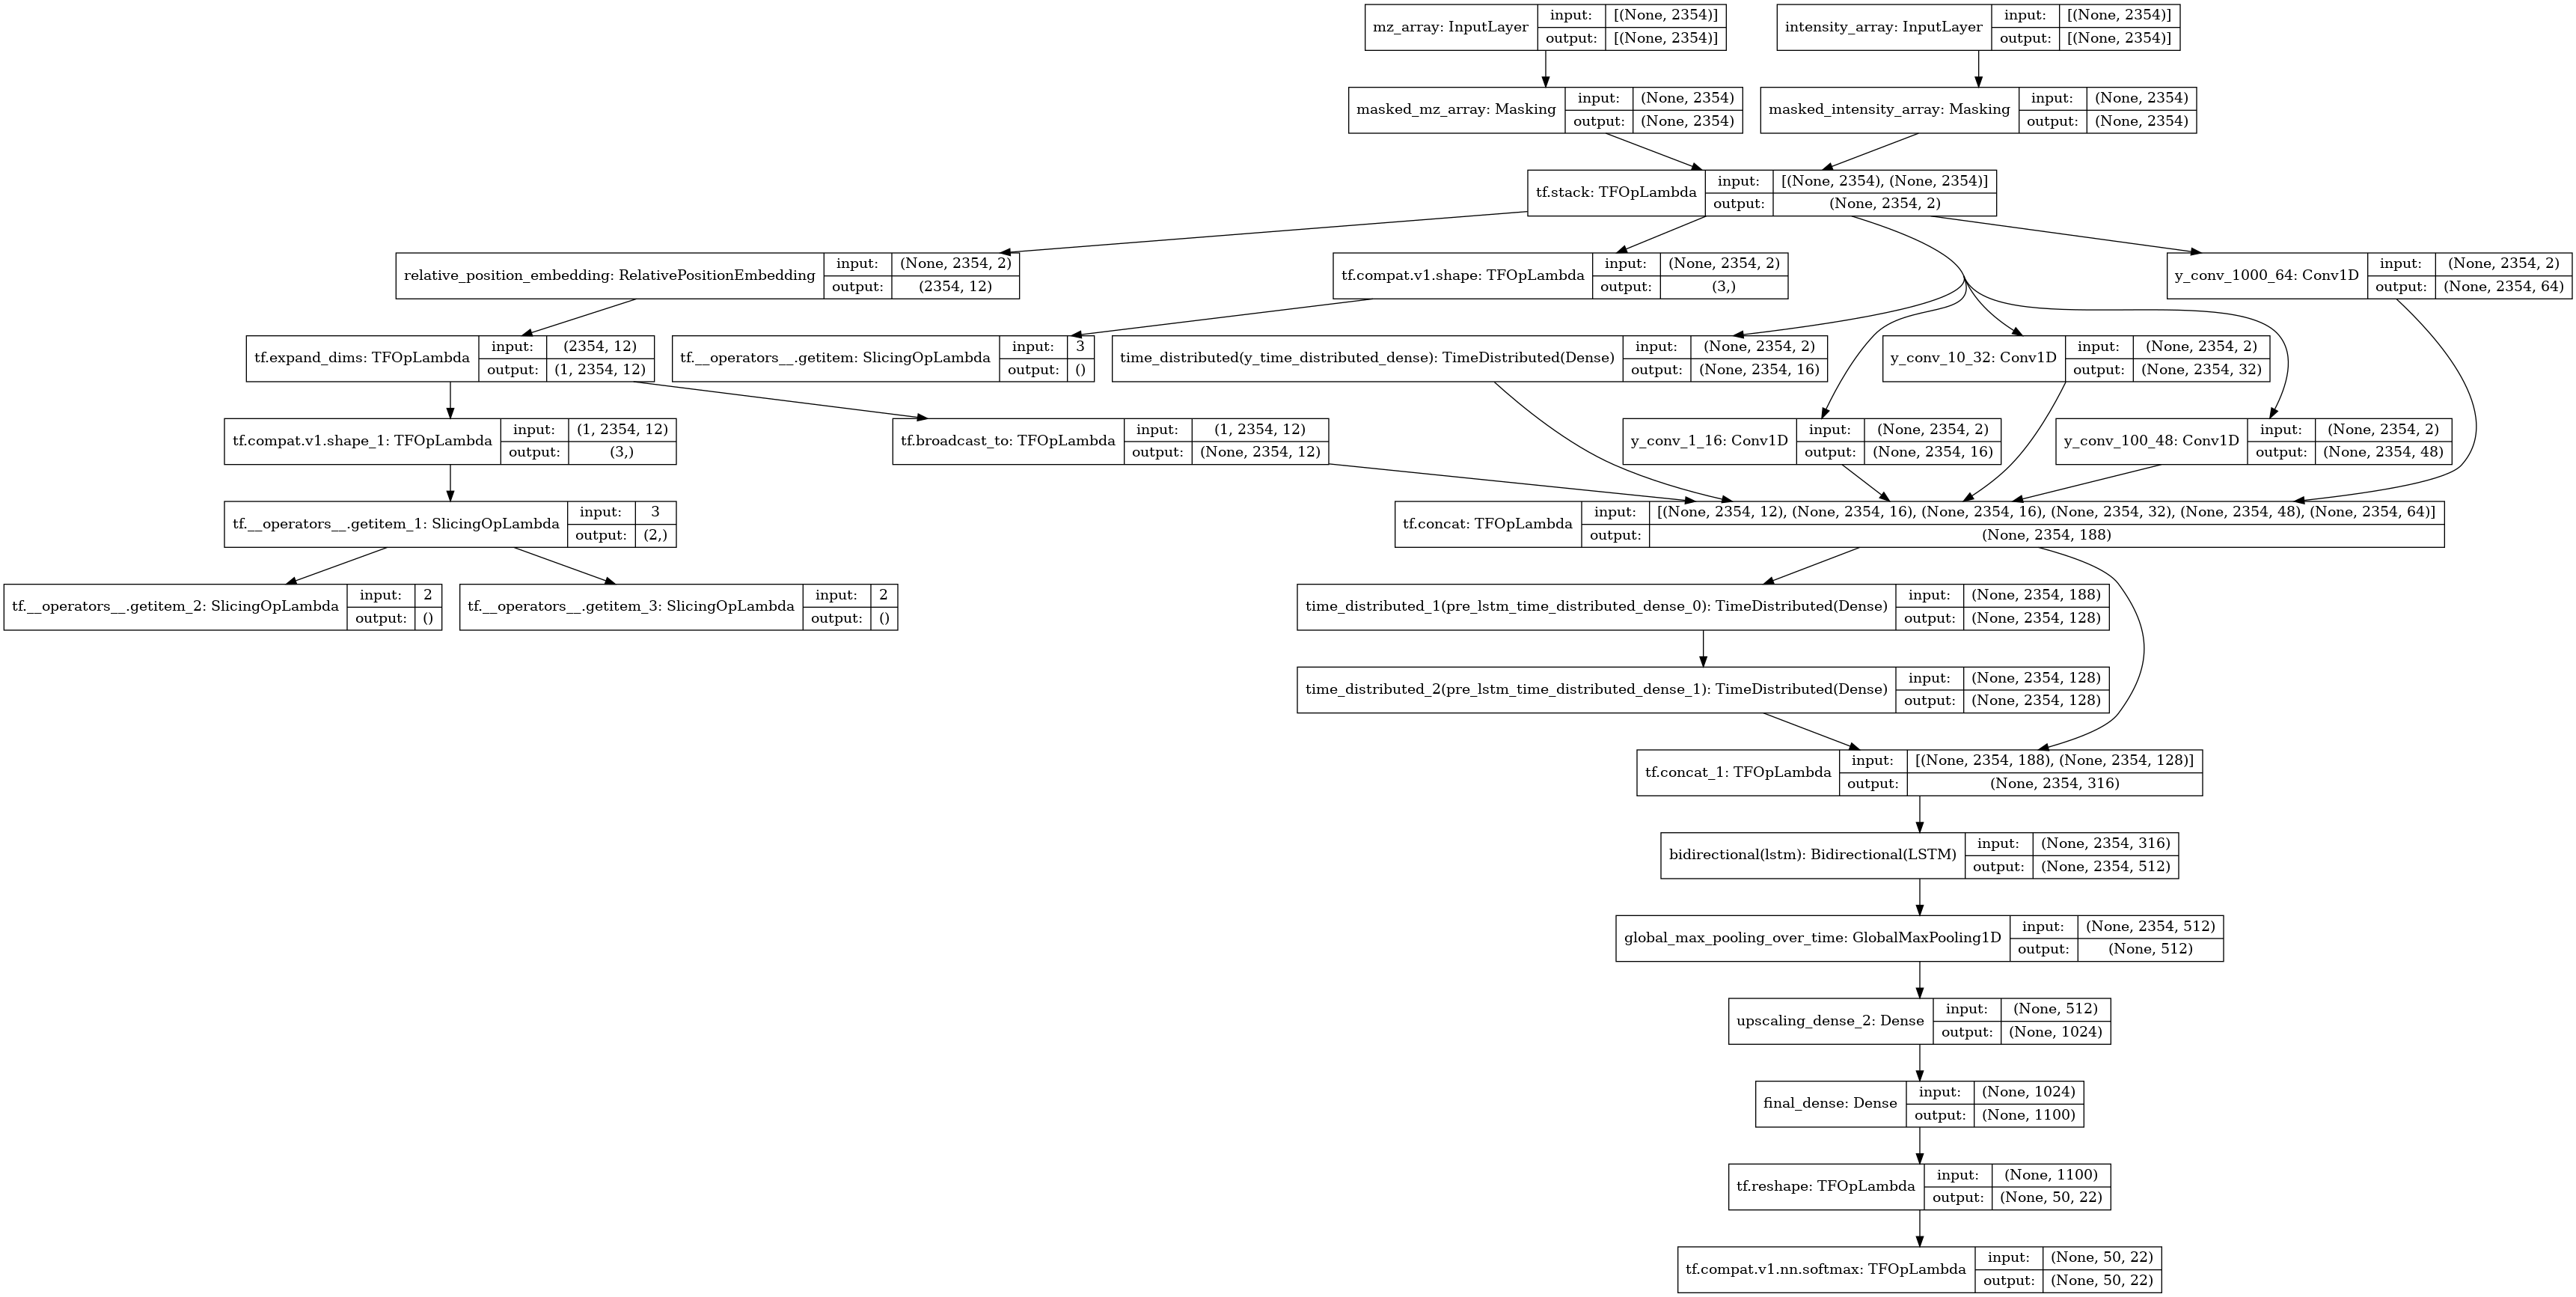

In [23]:
tf.keras.utils.plot_model(
    model=model,
    to_file=os.path.join(MODEL_PATH, "model.png"),
    show_shapes=True
)

In [24]:
with open(os.path.join(MODEL_PATH, "summary.txt"), 'w') as file:
    def write_lines(line: str) -> None:
        file.write(line)
        file.write("\n")
    model.summary(print_fn=write_lines)
model.summary()

Model: "mmproteo_lstm_with_pooling_and_position_20210628-135030"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
mz_array (InputLayer)           [(None, 2354)]       0                                            
__________________________________________________________________________________________________
intensity_array (InputLayer)    [(None, 2354)]       0                                            
__________________________________________________________________________________________________
masked_mz_array (Masking)       (None, 2354)         0           mz_array[0][0]                   
__________________________________________________________________________________________________
masked_intensity_array (Masking (None, 2354)         0           intensity_array[0][0]            
____________________________________________

In [25]:
with open(os.path.join(MODEL_PATH, "model.json"), 'w') as file:
    file.write(model.to_json())

In [26]:
with open(os.path.join(MODEL_PATH, "model.yaml"), 'w') as file:
    file.write(model.to_yaml())

In [27]:
#assert False

## Training the Tensorflow Model

In [28]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [29]:
TENSORBOARD_LOG_DIR = os.path.join(MODEL_PATH, "tensorboard")
os.path.realpath(TENSORBOARD_LOG_DIR)

'/tf/workspace/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210628-135030/tensorboard'

In [30]:
%tensorboard --logdir $TENSORBOARD_LOG_DIR --bind_all

In [31]:
model.fit(x=datasets[TRAINING_TYPE].repeat(),
          validation_data=datasets[TEST_TYPE].repeat(), 
          validation_steps=500,
          epochs=15,
          steps_per_epoch=1_000,
          callbacks=callbacks.create_callbacks(
              tensorboard=True,
              progressbar=False,
              reduce_lr=True,
              early_stopping=True,
              checkpoints=True,
              csv=True,
              base_path=MODEL_PATH,
          )
         )

Epoch 1/15
1000/1000 [==============================] - 394s 390ms/step - loss: 1.0597 - sparse_categorical_accuracy: 0.6983 - sparse_categorical_crossentropy: 1.0597 - val_loss: 0.9474 - val_sparse_categorical_accuracy: 0.7261 - val_sparse_categorical_crossentropy: 0.9474


INFO:tensorflow:Assets written to: ../dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210628-135030/checkpoints/assets


INFO:tensorflow:Assets written to: ../dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210628-135030/checkpoints/assets


Epoch 2/15
1000/1000 [==============================] - 389s 389ms/step - loss: 1.0879 - sparse_categorical_accuracy: 0.6875 - sparse_categorical_crossentropy: 1.0879 - val_loss: 0.9555 - val_sparse_categorical_accuracy: 0.7259 - val_sparse_categorical_crossentropy: 0.9555


INFO:tensorflow:Assets written to: ../dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210628-135030/checkpoints/assets


INFO:tensorflow:Assets written to: ../dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210628-135030/checkpoints/assets


Epoch 3/15
1000/1000 [==============================] - 388s 388ms/step - loss: 1.0988 - sparse_categorical_accuracy: 0.6848 - sparse_categorical_crossentropy: 1.0988 - val_loss: 0.9551 - val_sparse_categorical_accuracy: 0.7247 - val_sparse_categorical_crossentropy: 0.9551


INFO:tensorflow:Assets written to: ../dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210628-135030/checkpoints/assets


INFO:tensorflow:Assets written to: ../dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210628-135030/checkpoints/assets


Epoch 4/15
1000/1000 [==============================] - 389s 389ms/step - loss: 1.0538 - sparse_categorical_accuracy: 0.6966 - sparse_categorical_crossentropy: 1.0538 - val_loss: 0.9378 - val_sparse_categorical_accuracy: 0.7288 - val_sparse_categorical_crossentropy: 0.9378


INFO:tensorflow:Assets written to: ../dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210628-135030/checkpoints/assets


INFO:tensorflow:Assets written to: ../dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210628-135030/checkpoints/assets


Epoch 5/15
1000/1000 [==============================] - 389s 389ms/step - loss: 1.0330 - sparse_categorical_accuracy: 0.7020 - sparse_categorical_crossentropy: 1.0330 - val_loss: 0.9416 - val_sparse_categorical_accuracy: 0.7295 - val_sparse_categorical_crossentropy: 0.9416


INFO:tensorflow:Assets written to: ../dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210628-135030/checkpoints/assets


INFO:tensorflow:Assets written to: ../dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210628-135030/checkpoints/assets


Epoch 6/15
1000/1000 [==============================] - 389s 389ms/step - loss: 1.0579 - sparse_categorical_accuracy: 0.6945 - sparse_categorical_crossentropy: 1.0579 - val_loss: 0.9500 - val_sparse_categorical_accuracy: 0.7267 - val_sparse_categorical_crossentropy: 0.9500


INFO:tensorflow:Assets written to: ../dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210628-135030/checkpoints/assets


INFO:tensorflow:Assets written to: ../dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210628-135030/checkpoints/assets


Epoch 7/15
1000/1000 [==============================] - 388s 389ms/step - loss: 1.1148 - sparse_categorical_accuracy: 0.6780 - sparse_categorical_crossentropy: 1.1148 - val_loss: 0.9635 - val_sparse_categorical_accuracy: 0.7242 - val_sparse_categorical_crossentropy: 0.9635


INFO:tensorflow:Assets written to: ../dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210628-135030/checkpoints/assets


INFO:tensorflow:Assets written to: ../dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210628-135030/checkpoints/assets


Epoch 8/15
1000/1000 [==============================] - 389s 389ms/step - loss: 1.1487 - sparse_categorical_accuracy: 0.6692 - sparse_categorical_crossentropy: 1.1487 - val_loss: 0.9619 - val_sparse_categorical_accuracy: 0.7257 - val_sparse_categorical_crossentropy: 0.9619


INFO:tensorflow:Assets written to: ../dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210628-135030/checkpoints/assets


INFO:tensorflow:Assets written to: ../dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210628-135030/checkpoints/assets


Epoch 9/15
1000/1000 [==============================] - 389s 389ms/step - loss: 1.1388 - sparse_categorical_accuracy: 0.6719 - sparse_categorical_crossentropy: 1.1388 - val_loss: 0.9504 - val_sparse_categorical_accuracy: 0.7256 - val_sparse_categorical_crossentropy: 0.9504


INFO:tensorflow:Assets written to: ../dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210628-135030/checkpoints/assets


INFO:tensorflow:Assets written to: ../dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210628-135030/checkpoints/assets


Epoch 10/15
1000/1000 [==============================] - 388s 389ms/step - loss: 1.1087 - sparse_categorical_accuracy: 0.6798 - sparse_categorical_crossentropy: 1.1087 - val_loss: 0.9383 - val_sparse_categorical_accuracy: 0.7268 - val_sparse_categorical_crossentropy: 0.9383


INFO:tensorflow:Assets written to: ../dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210628-135030/checkpoints/assets


INFO:tensorflow:Assets written to: ../dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210628-135030/checkpoints/assets


Epoch 11/15
1000/1000 [==============================] - 388s 388ms/step - loss: 1.1255 - sparse_categorical_accuracy: 0.6760 - sparse_categorical_crossentropy: 1.1255 - val_loss: 0.9318 - val_sparse_categorical_accuracy: 0.7291 - val_sparse_categorical_crossentropy: 0.9318


INFO:tensorflow:Assets written to: ../dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210628-135030/checkpoints/assets


INFO:tensorflow:Assets written to: ../dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210628-135030/checkpoints/assets


Epoch 12/15
1000/1000 [==============================] - 389s 389ms/step - loss: 1.1365 - sparse_categorical_accuracy: 0.6737 - sparse_categorical_crossentropy: 1.1365 - val_loss: 0.9345 - val_sparse_categorical_accuracy: 0.7297 - val_sparse_categorical_crossentropy: 0.9345


INFO:tensorflow:Assets written to: ../dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210628-135030/checkpoints/assets


INFO:tensorflow:Assets written to: ../dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210628-135030/checkpoints/assets


Epoch 13/15
1000/1000 [==============================] - 389s 389ms/step - loss: 1.1008 - sparse_categorical_accuracy: 0.6839 - sparse_categorical_crossentropy: 1.1008 - val_loss: 0.9316 - val_sparse_categorical_accuracy: 0.7299 - val_sparse_categorical_crossentropy: 0.9316


INFO:tensorflow:Assets written to: ../dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210628-135030/checkpoints/assets


INFO:tensorflow:Assets written to: ../dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210628-135030/checkpoints/assets


Epoch 14/15
1000/1000 [==============================] - 389s 389ms/step - loss: 1.0837 - sparse_categorical_accuracy: 0.6877 - sparse_categorical_crossentropy: 1.0837 - val_loss: 0.9500 - val_sparse_categorical_accuracy: 0.7272 - val_sparse_categorical_crossentropy: 0.9500


INFO:tensorflow:Assets written to: ../dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210628-135030/checkpoints/assets


INFO:tensorflow:Assets written to: ../dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210628-135030/checkpoints/assets


Epoch 15/15
1000/1000 [==============================] - 389s 389ms/step - loss: 1.1152 - sparse_categorical_accuracy: 0.6782 - sparse_categorical_crossentropy: 1.1152 - val_loss: 0.9262 - val_sparse_categorical_accuracy: 0.7295 - val_sparse_categorical_crossentropy: 0.9262


INFO:tensorflow:Assets written to: ../dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210628-135030/checkpoints/assets


INFO:tensorflow:Assets written to: ../dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210628-135030/checkpoints/assets


## Evaluating the Tensorflow Model

In [32]:
decode_idx: Callable[[np.ndarray], np.ndarray] = np.vectorize(idx_to_char.get)

In [33]:
evaluator = evaluation.SequenceEvaluator(
    dataset=datasets[EVAL_TYPE],
    decode_func=decode_idx,
    batch_size=BATCH_SIZE,
    separator=" ",
    padding_character=PROCESSING_INFO['padding_characters'][SEQ],
)

In [34]:
evaluator.evaluate_model(model)

1250/1250 [==============================] - 150s 119ms/step - loss: 0.9356 - sparse_categorical_accuracy: 0.7271 - sparse_categorical_crossentropy: 0.9356


[0.9355901479721069, 0.7271329760551453, 0.9355893731117249]

In [35]:
eval_df, (x_eval, y_eval, y_pred) = evaluator.evaluate_model_visually(
    model=model,
    sample_size=20,
    keep_separator=True,
)
eval_df

,predicted,true
0,V L L E L L L A L _ _ _ _ _ _ _ _ _ _,K A N I T Q V G L D K L N I E L H R
1,A L V E A L G A A A A _,Y D R L A D T G I T K
2,A L L E A L G A A A A,I R E D F P I L S R
3,L L L L L L L R _ _ _ _ _ _ _ _ _,V T V D P E N V T T T T L T V R
4,A L V E A L G A A A A _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,G N F A S S Q Y N S T D G V L H S E N T F S G I R
5,A L V E A L G A A A A A _ _,M S L G G V H D E A E I R
6,V L L L L L L A _ _ _,Q F D M(Oxidation) Q V Y T N R
7,A L V E A L G A A,W G Y E L A E R
8,L L L L L L L R _ _ _ _ _,G V M T N K E A A E L K
9,A L L L A L G A A L A A E A,Y R E E L V G E A N Y A R


In [36]:
eval_df.predicted.map(print)
None

V L L E L L L A L _ _ _ _ _ _ _ _ _ _
A L V E A L G A A A A _
A L L E A L G A A A A
L L L L L L L R _ _ _ _ _ _ _ _ _
A L V E A L G A A A A _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
A L V E A L G A A A A A _ _
V L L L L L L A _ _ _
A L V E A L G A A
L L L L L L L R _ _ _ _ _
A L L L A L G A A L A A E A
A L V A A L G A A A A A E A _ _ _ _ _ _
A L A L A L G A A A A A
L L L L L L L R _ _ _
L L L L L L L R _
V L L E L L L A L A _ _ _ _ _ _
A L V E A L G A A A
L L L L L L R _ _ _ _ _ _ _ _ _ _ _
V L L E L L L A L R _ _ _ _ _ _ _
L L L E A L G A A
V L L E L L L A L A _ _ _ _ _ _ _ _ _ _ _


broken loss function?

In [37]:
np.argmax(y_pred[0], axis=1)

array([18,  9,  9,  3,  9,  9,  9,  0,  9, 21, 21, 21, 21, 21, 21, 21, 21,
       21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,
       21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21])

In [38]:
model.predict(datasets[EVAL_TYPE].take(1)).shape

(32, 50, 22)

In [39]:
y_pred.shape

(20, 50, 22)

In [40]:
y_pred

array([[[1.02070458e-01, 4.16519179e-04, 4.56595160e-02, ...,
         6.33274252e-03, 2.89670024e-02, 2.48143950e-09],
        [9.84267667e-02, 4.50521533e-04, 4.09034565e-02, ...,
         6.83527393e-03, 3.38096023e-02, 2.21484853e-09],
        [9.26778466e-02, 4.85537923e-04, 8.32822174e-02, ...,
         7.50574330e-03, 3.17370668e-02, 2.63684075e-09],
        ...,
        [1.27155131e-08, 5.23737997e-10, 5.00431224e-11, ...,
         5.68639025e-10, 1.02583797e-09, 9.99999762e-01],
        [2.54887200e-09, 2.57391974e-09, 2.91731611e-10, ...,
         4.22115898e-10, 3.71878472e-10, 9.99999881e-01],
        [5.84386006e-09, 7.65767283e-10, 6.19706841e-10, ...,
         6.93149760e-10, 8.01554934e-10, 1.00000000e+00]],

       [[1.10119656e-01, 5.38200780e-04, 4.33007516e-02, ...,
         7.35445134e-03, 2.88408976e-02, 1.84414617e-09],
        [1.11686379e-01, 5.38153865e-04, 4.28498276e-02, ...,
         6.34210045e-03, 3.34867164e-02, 1.97128491e-09],
        [9.51958969e-02, 